In [2]:
%matplotlib inline
import quandl
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as mpl
import random
import numpy as np
from datetime import datetime
import scipy.cluster.hierarchy as sch
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

In [3]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (16, 12)

# Load data
First objective is to load lots of different markets.  I am going to resample to use just monthly data.

In [5]:
df=pd.DataFrame()
df['SP500']=quandl.get("CHRIS/CME_SP1", authtoken=token).Settle
df['Gold']=quandl.get("CHRIS/CME_GC1", authtoken=token).Settle
df['USD Index']=quandl.get("CHRIS/ICE_DX1", authtoken=token).Settle
df['US 10Y']=quandl.get("CHRIS/CME_US1", authtoken=token).Settle
df['Wheat']=quandl.get("CHRIS/CME_W1", authtoken=token).Settle
df['Crude WTI']=quandl.get("CHRIS/CME_CL1", authtoken=token).Settle
df['US Treasury']=quandl.get("CHRIS/CME_TY1", authtoken=token).Settle


########### Extra Markets ###############################
#df['Eurostoxx 50']=quandl.get("CHRIS/EUREX_FESX1", authtoken=token).Settle
#df['Russel']=quandl.get("CHRIS/ICE_TF1", authtoken=token).Settle
#df['Russel']=quandl.get("CHRIS/ICE_TF1", authtoken=token).Settle
#df['Euro']=quandl.get("CHRIS/CME_EC1", authtoken=token).Settle
#df['GBP']=quandl.get("CHRIS/CME_BP1", authtoken=token).Settle
#df['Corn']=quandl.get("CHRIS/CME_C1", authtoken=token).Settle
#df['Eurodollar']=quandl.get("CHRIS/CME_ED1", authtoken=token).Settle
#df['Copper']=quandl.get("CHRIS/CME_HG1", authtoken=token).Settle

In [27]:
price=df.resample(rule='m',how='last')
pct_rtns = price.pct_change()

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


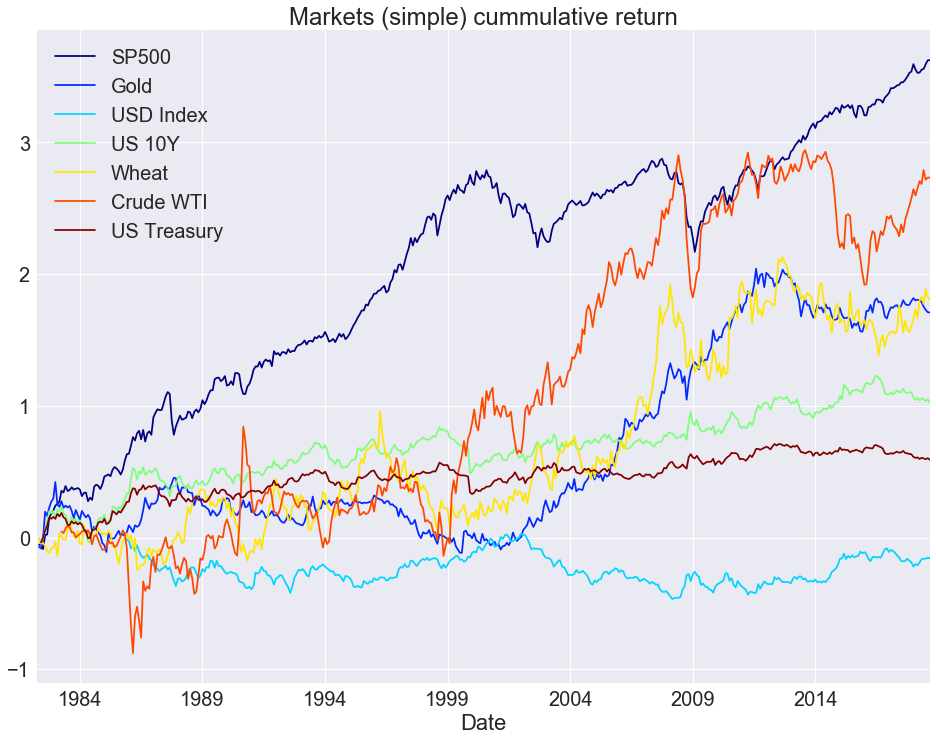

In [28]:
pct_rtns.cumsum().plot(colormap='jet',title='Markets (simple) cummulative return')

# Now lets create some portfolios

Things to think about for each one

* Any look ahead bias?
* How does it work in practice?  E.g. how do you trade this?
* How much trading is required?
* How much overfitting risk is there? Or how robust is it?
* What is the Sharpe Ratio of each?



To calculate Sharpe you can use the simple formula below which takes a DataFrame or Series and outputs the Sharpe ratio.  You may notice there is no risk free rate in the calcuation and some might call this an "information ratio," but with futures this can be justified more on this in the talk

In [29]:
def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

In [30]:
final_portfolios=pd.DataFrame()

# 1/N  (Equal weighting)

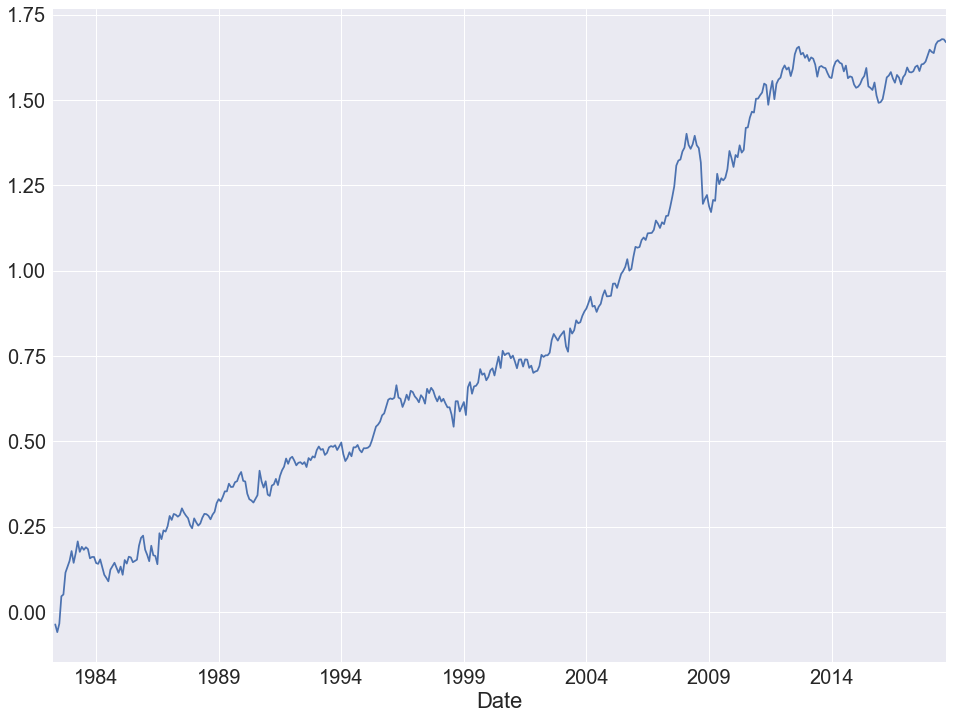

In [31]:
final_portfolios['1/N']=pct_rtns.mean(axis=1)
pct_rtns.mean(axis=1).cumsum().plot()

In [32]:
calc_Sharpe(pct_rtns.mean(axis=1))

0.58369014651837126

# Volatility scaled 1 / N

This approach requires scaling the returns by volatility.  The idea is we want equal "risk" contribution for each market

See the table below on the risk contribution to the overall portfolio (undiversified risk - non additive)

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=60,min_periods=60,adjust=True,ignore_na=False).std(bias=False)
  """Entry point for launching an IPython kernel.


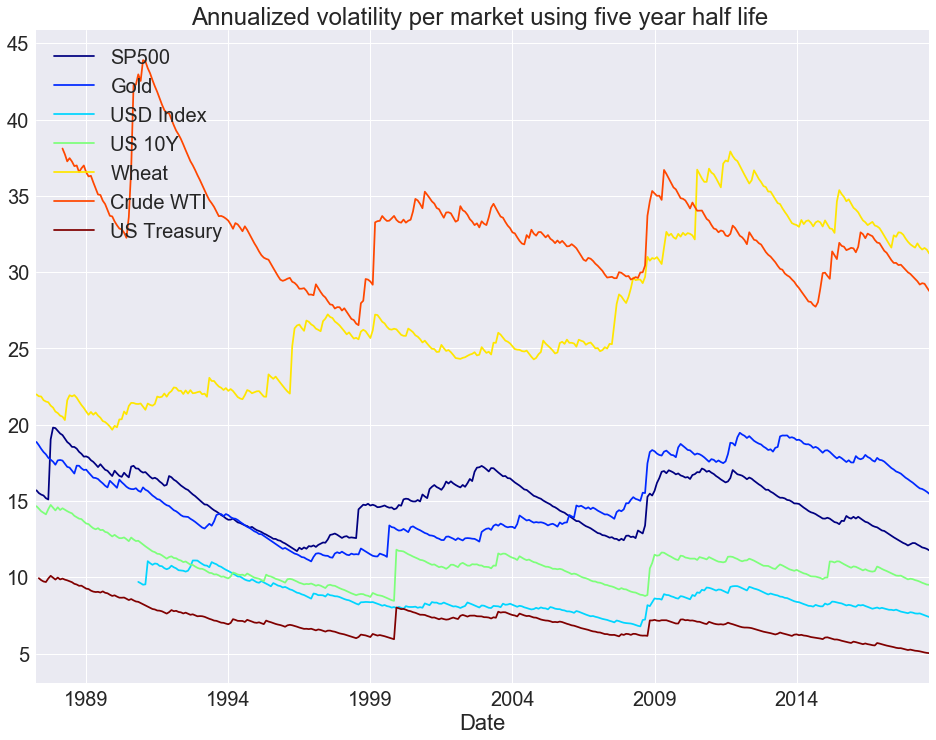

In [33]:
(pd.ewmstd(pct_rtns,60,min_periods=60)*341).dropna(how='all').plot(colormap='jet',
                                                                    title='Annualized volatility per market using five year half life ')

Full in sample

In [34]:
(pct_rtns/pct_rtns.std()).std()

SP500          1.0
Gold           1.0
USD Index      1.0
US 10Y         1.0
Wheat          1.0
Crude WTI      1.0
US Treasury    1.0
dtype: float64

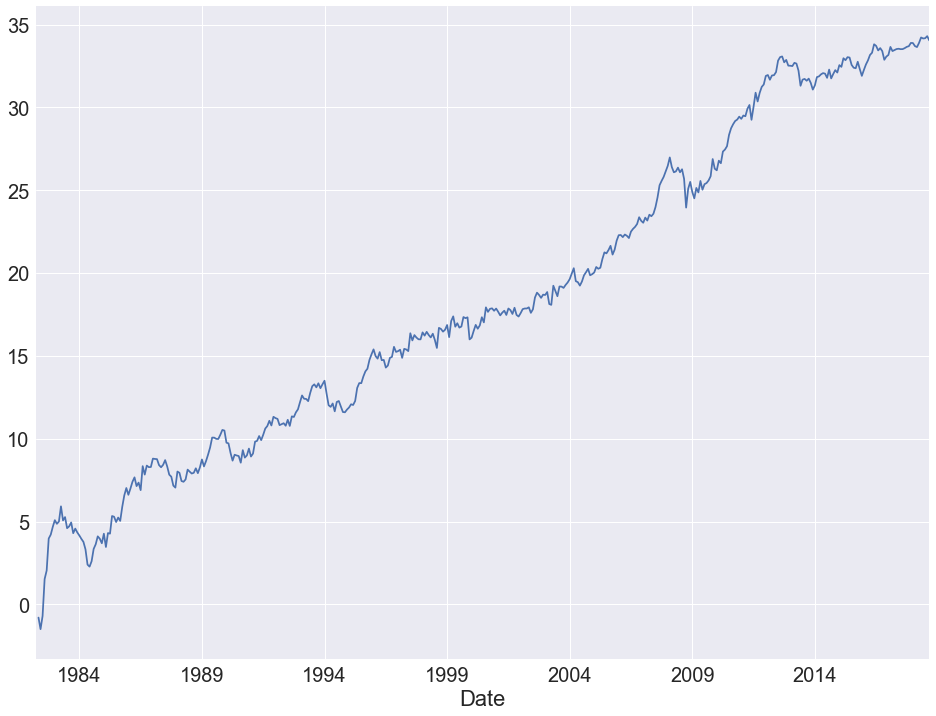

In [35]:
final_portfolios['1/N Vol In Sample']=(pct_rtns/pct_rtns.std()).mean(axis=1)
(pct_rtns/pct_rtns.std()).mean(axis=1).cumsum().plot()

In [36]:
calc_Sharpe((pct_rtns/pct_rtns.std()).mean(axis=1))

0.64112705075458809

# Out of sample

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=36,min_periods=36,adjust=True,ignore_na=False).std(bias=False)
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=36,min_periods=36,adjust=True,ignore_na=False).std(bias=False)
  


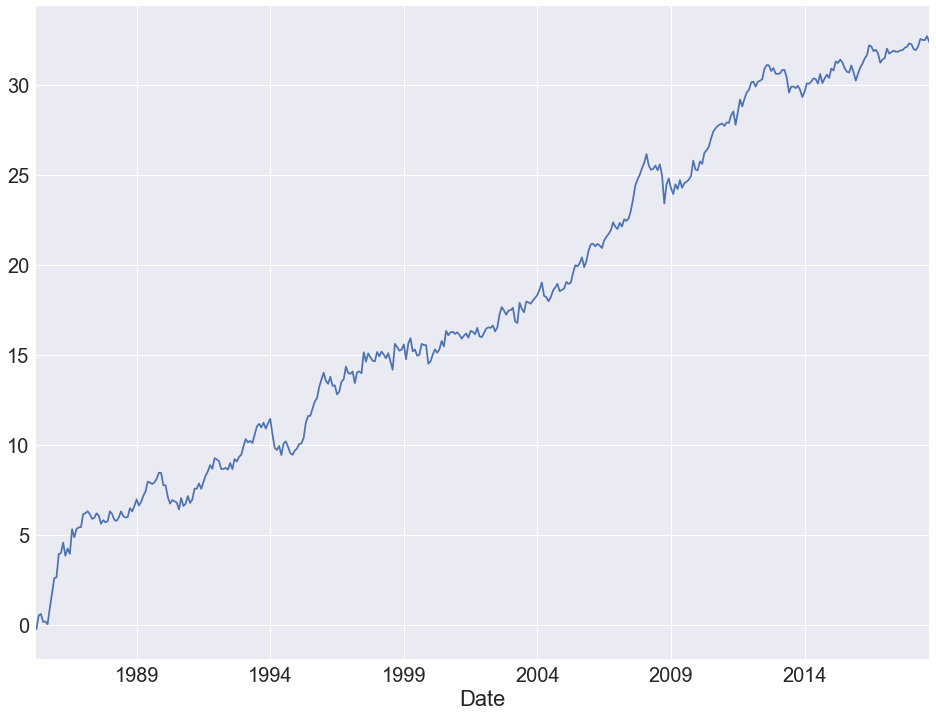

In [37]:
final_portfolios['1/N Vol Out Sample']=(pct_rtns/pd.ewmstd(pct_rtns,36,min_periods=36)).mean(axis=1)
(pct_rtns/pd.ewmstd(pct_rtns,36,min_periods=36)).mean(axis=1).cumsum().dropna().plot()

In [38]:
calc_Sharpe((pct_rtns/pd.ewmstd(pct_rtns,36,min_periods=36)).mean(axis=1))

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=36,min_periods=36,adjust=True,ignore_na=False).std(bias=False)
  """Entry point for launching an IPython kernel.


0.73115095524608698

# Capitalization weighted practice (but clearly WRONG!)

Since the idea of market capitalization for fututres doesn't really exist.  I just want to show for comparison how to create a capital weighted index using these futures.

Big assumption (and clearly very wrong), but let's assume price is the total capitalization of each future and each month we want to reblance.  

In [39]:
w=(price.T/price.sum(axis=1)).T

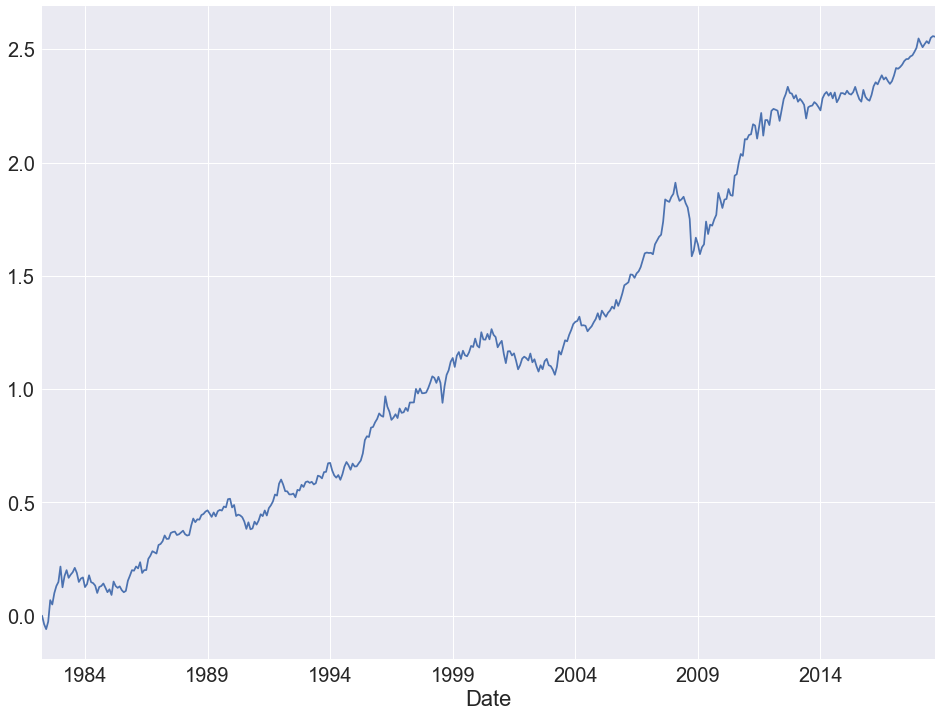

In [40]:
final_portfolios['Capital Weighted (Fake)']=(w*pct_rtns).sum(axis=1)
(w*pct_rtns).sum(axis=1).cumsum().plot()

In [41]:
calc_Sharpe((w*pct_rtns).sum(axis=1))

0.67771435920771816

# Markowtiz Optimization (full in sample)

Very simplistic version with no concept of risk adversion (investor indifference).  Also there are no constraints thus it allows for long short and unlimited leverage.  


 $$ \max_{x_t} \left [ \omega' \mu - \frac{\gamma}{2}\omega' \Sigma \omega \right ] $$
 
 Solving for the first order condition (FOC), we get:
 
 $$ \omega = \frac{1}{\gamma} \Sigma^{-1} \mu $$

In [42]:
# Helper function to calculate weights
# give the function pandas DataFrame and output is a vector of portfolio weights (pandas Series)
def mean_variance(data):
    sigma=data.cov().values
    mu=data.mean().values
    inverse = np.linalg.inv(sigma)
    return pd.Series(inverse.dot(mu),index=data.mean().index)

In [43]:
w=mean_variance(pct_rtns)

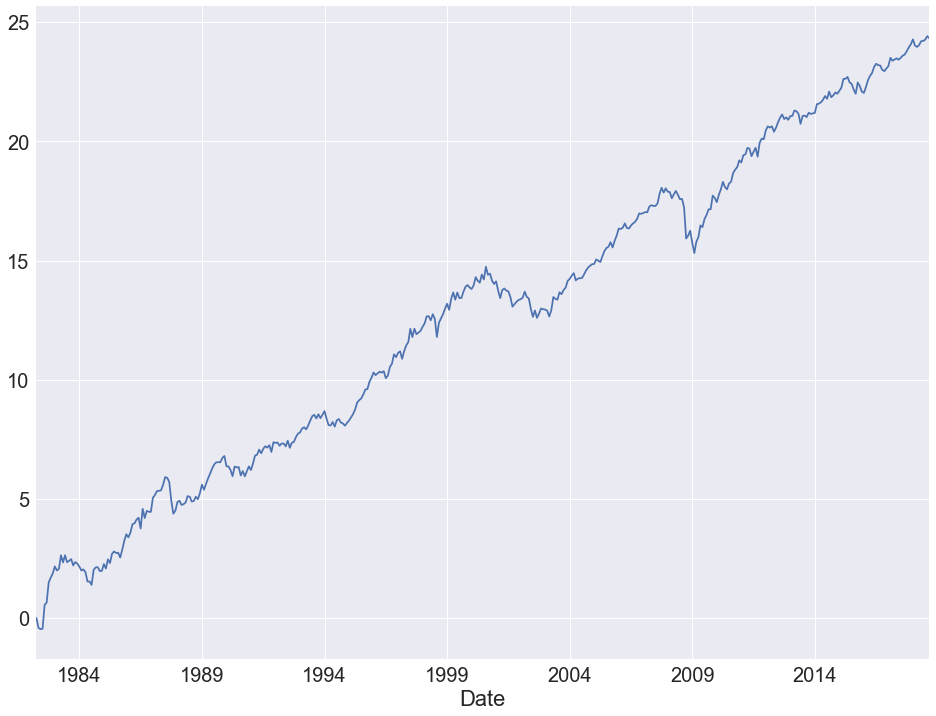

In [44]:
final_portfolios['Mean Variance']=((w*pct_rtns).sum(axis=1))
((w*pct_rtns).sum(axis=1)).cumsum().plot()

In [45]:
calc_Sharpe(((w*pct_rtns).sum(axis=1)))

0.81372950922312992

# Final Results

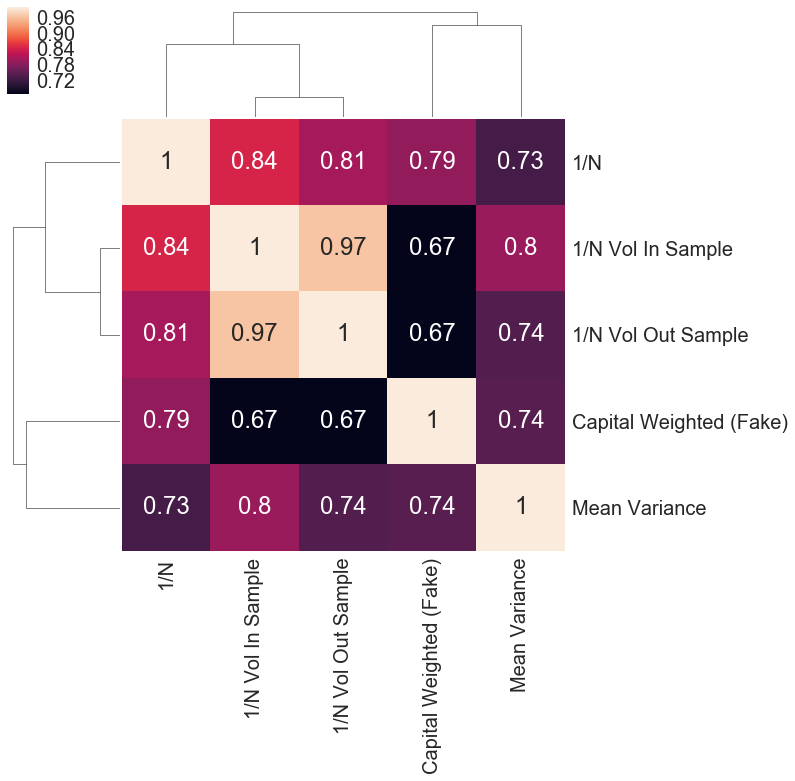

In [46]:
sns.clustermap(final_portfolios.corr(),annot=True)

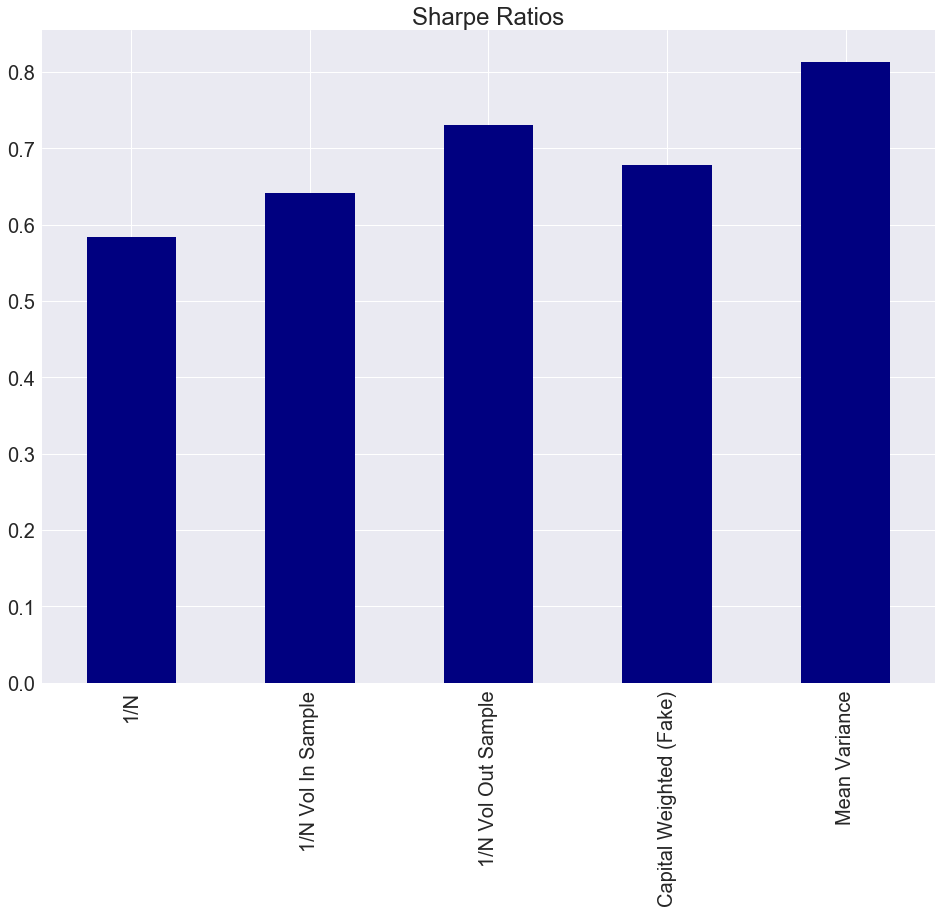

In [47]:
calc_Sharpe(final_portfolios).plot(kind='bar',colormap='jet',title='Sharpe Ratios')